
# Competition Intensity Niches with Gradient Boosting

This notebook follows the first initiative in `docs/ML/analisi ml da fare.md` by predicting competition intensity for NAICS 561612 contracts and highlighting low-competition, high-value niches that can improve procurement targeting.



## Workflow overview
- Load the filtered USAspending prime transactions for NAICS 561612 directly from SQLite.
- Prepare modeling features without using obvious temporal identifiers such as fiscal year.
- Train HistGradientBoosting models to predict offer counts and flag low-competition bids.
- Quantify model performance and permutation-based feature effects.
- Surface and visualize niches where competition is sparse but award values stay high.



## 1. Imports and project paths


In [1]:

from __future__ import annotations

import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
)
from sklearn.model_selection import train_test_split

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "scripts").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from scripts import competition_intensity_utils as ciu
from scripts import usaspending_utils as usu

sns.set_theme(style="whitegrid", context="talk")
pd.set_option("display.max_columns", 30)



## 2. Load security-services contracts
The dataset lives in `db/prime_transactions_filtered.sqlite` and already excludes unrelated NAICS codes. We further filter to NAICS 561612 (security services) and keep only awards where both the solicitation procedures and extent_competed fields indicate a fully open competition.


In [2]:

DB_PATH = PROJECT_ROOT / "db" / "prime_transactions_filtered.sqlite"

with usu.get_connection(DB_PATH) as conn:
    PRIME_TX_TABLE = usu.get_prime_transactions_table_name(conn)

raw_df = ciu.load_security_transactions_from_sqlite(
    DB_PATH,
    table_name=PRIME_TX_TABLE,
)

print(f"Loaded {len(raw_df):,} security contracts with {raw_df.shape[1]} fields.")
raw_df.head()


Loaded 220,528 security contracts with 16 fields.


,action_date,awarding_agency_name,awarding_sub_agency_name,awarding_office_name,extent_competed,type_of_set_aside,solicitation_procedures,type_of_contract_pricing,product_or_service_code,product_or_service_code_description,primary_place_of_performance_state_code,number_of_offers_received,base_and_all_options_value,total_dollars_obligated,naics_code,naics_description
0,2024-11-26,Government Accountability Office,"GAO, Except Comptroller General",GOVERNMENT ACCOUNTABILITY OFFICE,FULL AND OPEN COMPETITION,,SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,FIRM FIXED PRICE,R430,SUPPORT- PROFESSIONAL: PHYSICAL SECURITY AND B...,,2,0.00,0.00,561612,SECURITY GUARDS AND PATROL SERVICES
1,2025-02-10,Government Accountability Office,"GAO, Except Comptroller General",GOVERNMENT ACCOUNTABILITY OFFICE,FULL AND OPEN COMPETITION,,SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,FIRM FIXED PRICE,R430,SUPPORT- PROFESSIONAL: PHYSICAL SECURITY AND B...,,2,737962.78,0.00,561612,SECURITY GUARDS AND PATROL SERVICES
2,2013-03-21,Government Accountability Office,"GAO, Except Comptroller General",GAO ACQUISITION MANAGEMENT,FULL AND OPEN COMPETITION,NO SET ASIDE USED.,NEGOTIATED PROPOSAL/QUOTE,FIRM FIXED PRICE,S206,HOUSEKEEPING- GUARD,,1,256345.56,,561612,SECURITY GUARDS AND PATROL SERVICES
3,2014-08-19,Government Accountability Office,"GAO, Except Comptroller General",GAO ACQUISITION MANAGEMENT,FULL AND OPEN COMPETITION,NO SET ASIDE USED.,NEGOTIATED PROPOSAL/QUOTE,FIRM FIXED PRICE,S206,HOUSEKEEPING- GUARD,,1,245300.00,,561612,SECURITY GUARDS AND PATROL SERVICES
4,2018-12-06,Government Accountability Office,"GAO, Except Comptroller General",GOVERNMENT ACCOUNTABILITY OFFICE,COMPETED UNDER SAP,NO SET ASIDE USED.,SIMPLIFIED ACQUISITION,FIRM FIXED PRICE,S211,HOUSEKEEPING- SURVEILLANCE,DC,1,10941.60,10941.60,561612,SECURITY GUARDS AND PATROL SERVICES


In [3]:
open_df = ciu.filter_open_competitions(raw_df)

print(
    f"Retained {len(open_df):,} open competitions out of {len(raw_df):,} total security awards "
    f"({len(open_df) / len(raw_df):.1%})."
)
open_df.head()

Retained 137,819 open competitions out of 220,528 total security awards (62.5%).


,action_date,awarding_agency_name,awarding_sub_agency_name,awarding_office_name,extent_competed,type_of_set_aside,solicitation_procedures,type_of_contract_pricing,product_or_service_code,product_or_service_code_description,primary_place_of_performance_state_code,number_of_offers_received,base_and_all_options_value,total_dollars_obligated,naics_code,naics_description
2,2013-03-21,Government Accountability Office,"GAO, Except Comptroller General",GAO ACQUISITION MANAGEMENT,FULL AND OPEN COMPETITION,NO SET ASIDE USED.,NEGOTIATED PROPOSAL/QUOTE,FIRM FIXED PRICE,S206,HOUSEKEEPING- GUARD,,1,256345.56,,561612,SECURITY GUARDS AND PATROL SERVICES
3,2014-08-19,Government Accountability Office,"GAO, Except Comptroller General",GAO ACQUISITION MANAGEMENT,FULL AND OPEN COMPETITION,NO SET ASIDE USED.,NEGOTIATED PROPOSAL/QUOTE,FIRM FIXED PRICE,S206,HOUSEKEEPING- GUARD,,1,245300.00,,561612,SECURITY GUARDS AND PATROL SERVICES
4,2018-12-06,Government Accountability Office,"GAO, Except Comptroller General",GOVERNMENT ACCOUNTABILITY OFFICE,COMPETED UNDER SAP,NO SET ASIDE USED.,SIMPLIFIED ACQUISITION,FIRM FIXED PRICE,S211,HOUSEKEEPING- SURVEILLANCE,DC,1,10941.60,10941.60,561612,SECURITY GUARDS AND PATROL SERVICES
17,2023-09-14,Department of Agriculture,Office of the Chief Financial Officer,"USDA, OCP-POD-ACQ-MGMT-BRANCH-FTC",COMPETED UNDER SAP,SERVICE DISABLED VETERAN OWNED SMALL BUSINESS ...,SIMPLIFIED ACQUISITION,FIRM FIXED PRICE,R499,SUPPORT- PROFESSIONAL: OTHER,GA,1,0.00,376000.00,561612,SECURITY GUARDS AND PATROL SERVICES
25,2021-08-30,Department of Agriculture,Forest Service,PACIFIC NORTHWEST REGIONAL OFFICE,COMPETED UNDER SAP,NO SET ASIDE USED.,SIMPLIFIED ACQUISITION,FIRM FIXED PRICE,R430,SUPPORT- PROFESSIONAL: PHYSICAL SECURITY AND B...,WA,1,718678.78,718678.78,561612,SECURITY GUARDS AND PATROL SERVICES


In [4]:
summary_stats = pd.DataFrame({
    "count": [len(open_df)],
    "contracts_with_offer_counts": [open_df["number_of_offers_received"].notna().sum()],
    "median_offers": [pd.to_numeric(open_df["number_of_offers_received"], errors="coerce").median()],
    "mean_award_value": [pd.to_numeric(open_df["base_and_all_options_value"], errors="coerce").mean()],
})
summary_stats

,count,contracts_with_offer_counts,median_offers,mean_award_value
0,137819,137819,3.0,1.503557e+06



## 3. Feature preparation
We keep competition-related categorical descriptors plus dollar values, intentionally excluding fields such as fiscal year that would act as obvious time proxies.


In [5]:

prepared_df = ciu.prepare_competition_dataset(open_df)

categorical_features = [
    "awarding_agency_name",
    "awarding_sub_agency_name",
    "awarding_office_name",
    "extent_competed",
    "type_of_set_aside",
    "solicitation_procedures",
    "type_of_contract_pricing",
    "product_or_service_code",
    "product_or_service_code_description",
    "primary_place_of_performance_state_code",
]

numeric_features = [
    "base_and_all_options_value",
    "total_dollars_obligated",
    "log_base_and_all_options_value",
]

display(prepared_df[categorical_features + numeric_features].head())
print(f"Prepared dataset contains {len(prepared_df):,} observations.")


,awarding_agency_name,awarding_sub_agency_name,awarding_office_name,extent_competed,type_of_set_aside,solicitation_procedures,type_of_contract_pricing,product_or_service_code,product_or_service_code_description,primary_place_of_performance_state_code,base_and_all_options_value,total_dollars_obligated,log_base_and_all_options_value
2,Government Accountability Office,"GAO, Except Comptroller General",GAO ACQUISITION MANAGEMENT,FULL AND OPEN COMPETITION,NO SET ASIDE USED.,NEGOTIATED PROPOSAL/QUOTE,FIRM FIXED PRICE,S206,HOUSEKEEPING- GUARD,,256345.56,0.00,5.408827
3,Government Accountability Office,"GAO, Except Comptroller General",GAO ACQUISITION MANAGEMENT,FULL AND OPEN COMPETITION,NO SET ASIDE USED.,NEGOTIATED PROPOSAL/QUOTE,FIRM FIXED PRICE,S206,HOUSEKEEPING- GUARD,,245300.00,0.00,5.389699
4,Government Accountability Office,"GAO, Except Comptroller General",GOVERNMENT ACCOUNTABILITY OFFICE,COMPETED UNDER SAP,NO SET ASIDE USED.,SIMPLIFIED ACQUISITION,FIRM FIXED PRICE,S211,HOUSEKEEPING- SURVEILLANCE,DC,10941.60,10941.60,4.039121
17,Department of Agriculture,Office of the Chief Financial Officer,"USDA, OCP-POD-ACQ-MGMT-BRANCH-FTC",COMPETED UNDER SAP,SERVICE DISABLED VETERAN OWNED SMALL BUSINESS ...,SIMPLIFIED ACQUISITION,FIRM FIXED PRICE,R499,SUPPORT- PROFESSIONAL: OTHER,GA,0.00,376000.00,0.000000
25,Department of Agriculture,Forest Service,PACIFIC NORTHWEST REGIONAL OFFICE,COMPETED UNDER SAP,NO SET ASIDE USED.,SIMPLIFIED ACQUISITION,FIRM FIXED PRICE,R430,SUPPORT- PROFESSIONAL: PHYSICAL SECURITY AND B...,WA,718678.78,718678.78,5.856535


Prepared dataset contains 116,839 observations.



## 4. Gradient boosting regression for offer counts


In [6]:

X = prepared_df[categorical_features + numeric_features]
y = prepared_df["number_of_offers_received"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

reg_pipeline = ciu.build_regression_pipeline(categorical_features, numeric_features)
reg_pipeline.fit(X_train, y_train)

y_pred = reg_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
reg_results = {
    "R2": r2_score(y_test, y_pred),
    "RMSE": np.sqrt(mse),
    "MAE": mean_absolute_error(y_test, y_pred),
}

pd.DataFrame([reg_results])


,R2,RMSE,MAE
0,0.923222,59.379711,12.058509


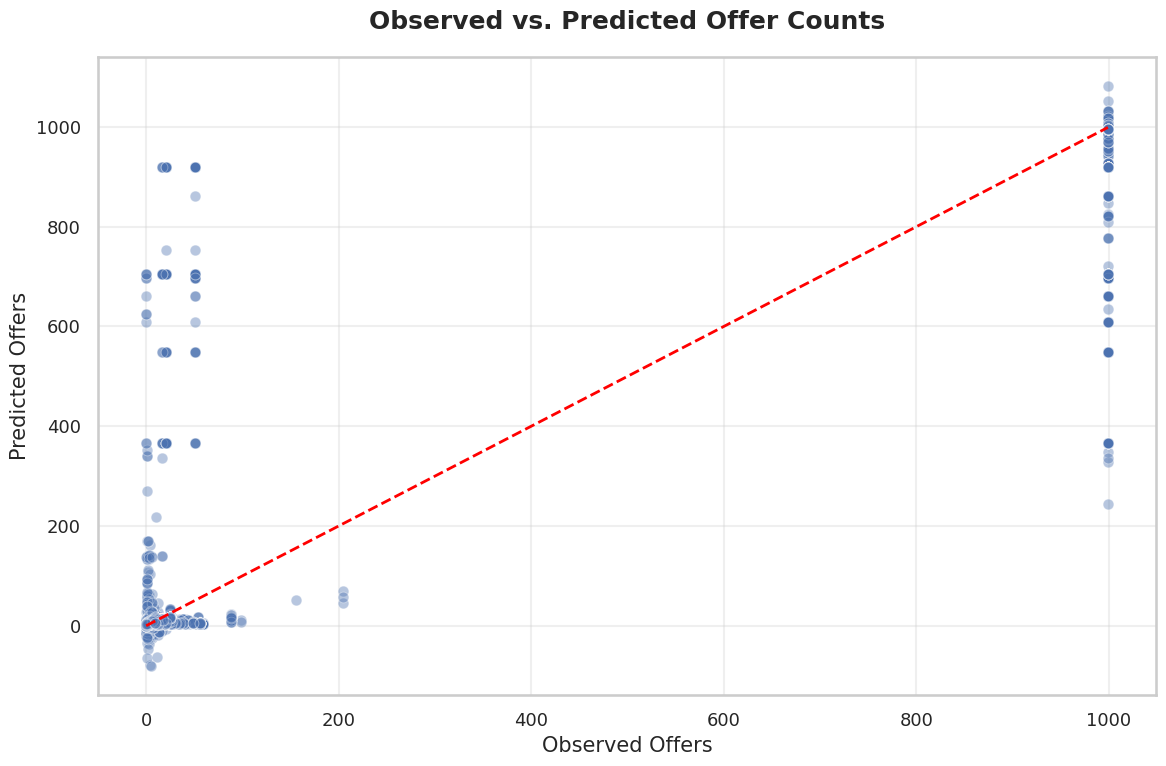

In [7]:

fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4, s=60, ax=ax)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", linewidth=2)
ax.set_title("Observed vs. Predicted Offer Counts", fontsize=18, weight="bold", pad=20)
ax.set_xlabel("Observed Offers", fontsize=15)
ax.set_ylabel("Predicted Offers", fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(True, alpha=0.3)
plt.tight_layout()
fig.savefig(PROJECT_ROOT / "docs" / "ML" / "images" / "regression_observed_vs_predicted.png", dpi=300, bbox_inches='tight')
plt.show()


In [8]:

perm = permutation_importance(
    reg_pipeline,
    X_test,
    y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=-1,
)
feature_names = reg_pipeline.named_steps["preprocess"].get_feature_names_out()
importance_df = (
    pd.DataFrame({"feature": feature_names, "importance": perm.importances_mean})
    .sort_values("importance", ascending=False)
    .head(15)
)
importance_df


,feature,importance
0,categorical__awarding_agency_name,0.997204
1,categorical__awarding_sub_agency_name,0.769914
8,categorical__product_or_service_code_description,0.042260
2,categorical__awarding_office_name,0.028531
9,categorical__primary_place_of_performance_stat...,0.010402
7,categorical__product_or_service_code,0.004806
5,categorical__solicitation_procedures,0.003822
6,categorical__type_of_contract_pricing,0.002947
10,numeric__base_and_all_options_value,0.002024
4,categorical__type_of_set_aside,0.000688


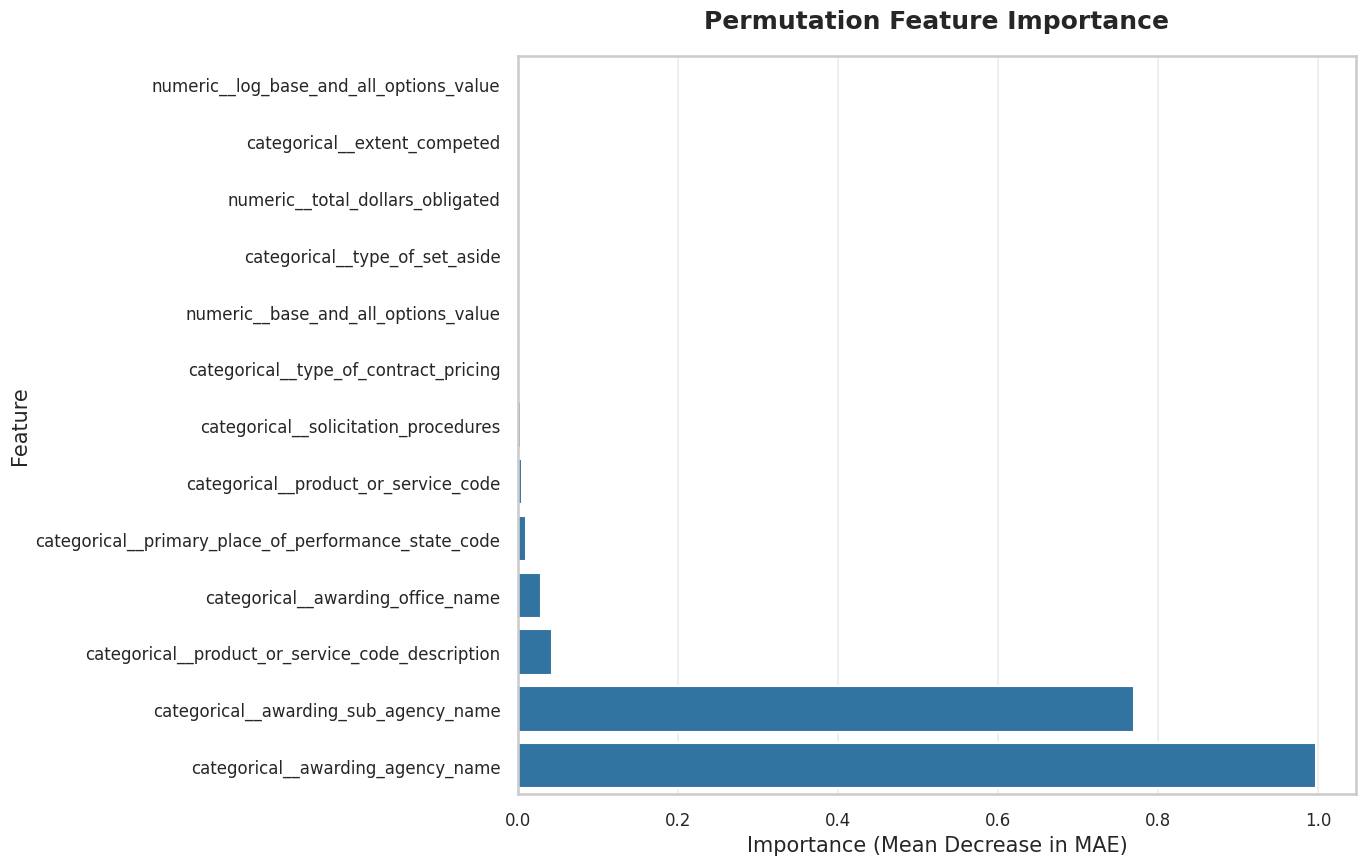

In [9]:
fig, ax = plt.subplots(figsize=(14, 9))
sns.barplot(
    data=importance_df.sort_values("importance", ascending=True),
    x="importance",
    y="feature",
    color="#1f77b4",
    ax=ax,
)
ax.set_title("Permutation Feature Importance", fontsize=18, weight="bold", pad=20)
ax.set_xlabel("Importance (Mean Decrease in MAE)", fontsize=15)
ax.set_ylabel("Feature", fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
fig.savefig(PROJECT_ROOT / "docs" / "ML" / "images" / "permutation_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()



## 5. Low-competition classifier


In [10]:

LOW_COMP_THRESHOLD = 3

y_low = (y <= LOW_COMP_THRESHOLD).astype(int)

X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(
    X,
    y_low,
    test_size=0.2,
    random_state=42,
    stratify=y_low,
)

clf_pipeline = ciu.build_low_competition_classifier(categorical_features, numeric_features)
clf_pipeline.fit(X_train_low, y_train_low)

y_pred_low = clf_pipeline.predict(X_test_low)

clf_results = {
    "precision_low_comp": precision_score(y_test_low, y_pred_low, zero_division=0),
    "recall_low_comp": recall_score(y_test_low, y_pred_low, zero_division=0),
    "support_low_comp": int(y_test_low.sum()),
}

pd.DataFrame([clf_results])


,precision_low_comp,recall_low_comp,support_low_comp
0,0.854528,0.934889,13930


                  precision    recall  f1-score   support

High competition       0.89      0.77      0.82      9438
 Low competition       0.85      0.93      0.89     13930

        accuracy                           0.87     23368
       macro avg       0.87      0.85      0.86     23368
    weighted avg       0.87      0.87      0.86     23368



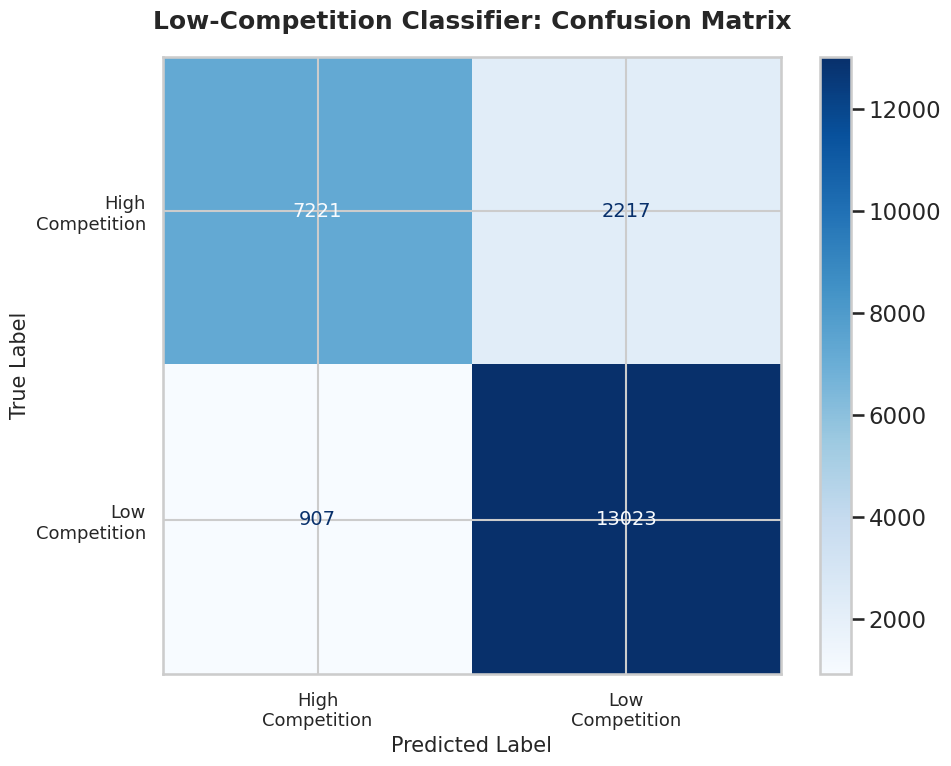

In [11]:

print(classification_report(y_test_low, y_pred_low, target_names=["High competition", "Low competition"]))

cm = confusion_matrix(y_test_low, y_pred_low, labels=[0, 1])
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["High\nCompetition", "Low\nCompetition"])
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title("Low-Competition Classifier: Confusion Matrix", fontsize=18, weight="bold", pad=20)
ax.set_xlabel("Predicted Label", fontsize=15)
ax.set_ylabel("True Label", fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=13)
for text in ax.texts:
    text.set_fontsize(14)
plt.tight_layout()
fig.savefig(PROJECT_ROOT / "docs" / "ML" / "images" / "confusion_matrix_low_competition.png", dpi=300, bbox_inches='tight')
plt.show()



## 6. Surface low-competition, high-value niches


In [12]:

niche_summary = ciu.summarize_low_competition_niches(
    prepared_df,
    group_cols=["awarding_agency_name", "product_or_service_code"],
    low_threshold=LOW_COMP_THRESHOLD,
    min_awards=15,
)

print(
    f"High-value cutoff (80th percentile) used for segmentation: ${niche_summary.attrs.get('high_value_cutoff', float('nan')):,.0f}"
)

top_niches = niche_summary.head(10).copy()
top_niches["segment"] = (
    top_niches["awarding_agency_name"].str.slice(stop=35)
    + " | PSC "
    + top_niches["product_or_service_code"].astype(str)
)
top_niches[
    [
        "awards",
        "avg_offers",
        "low_comp_share",
        "median_value",
        "hv_low_comp_count",
        "hv_low_comp_share",
        "niche_score",
    ]
]


High-value cutoff (80th percentile) used for segmentation: $25,000


,awards,avg_offers,low_comp_share,median_value,hv_low_comp_count,hv_low_comp_share,niche_score
0,69,1.130435,1.000000,693909.00,50,0.724638,502832.608696
1,48,2.625000,0.458333,737500.00,21,0.437500,322656.250000
2,16,1.000000,1.000000,532353.66,8,0.500000,266176.830000
3,139,8.194245,0.273381,347500.00,34,0.244604,85000.000000
4,24,1.000000,1.000000,122650.00,12,0.500000,61325.000000
5,20,3.000000,1.000000,117455.50,10,0.500000,58727.750000
6,17,1.000000,1.000000,63359.56,9,0.529412,33543.296471
7,949,4.326660,0.721812,34325.00,434,0.457323,15697.629083
8,29,6.689655,0.620690,40205.00,9,0.310345,12477.413793
9,30,1.866667,1.000000,19797.58,8,0.266667,5279.354667


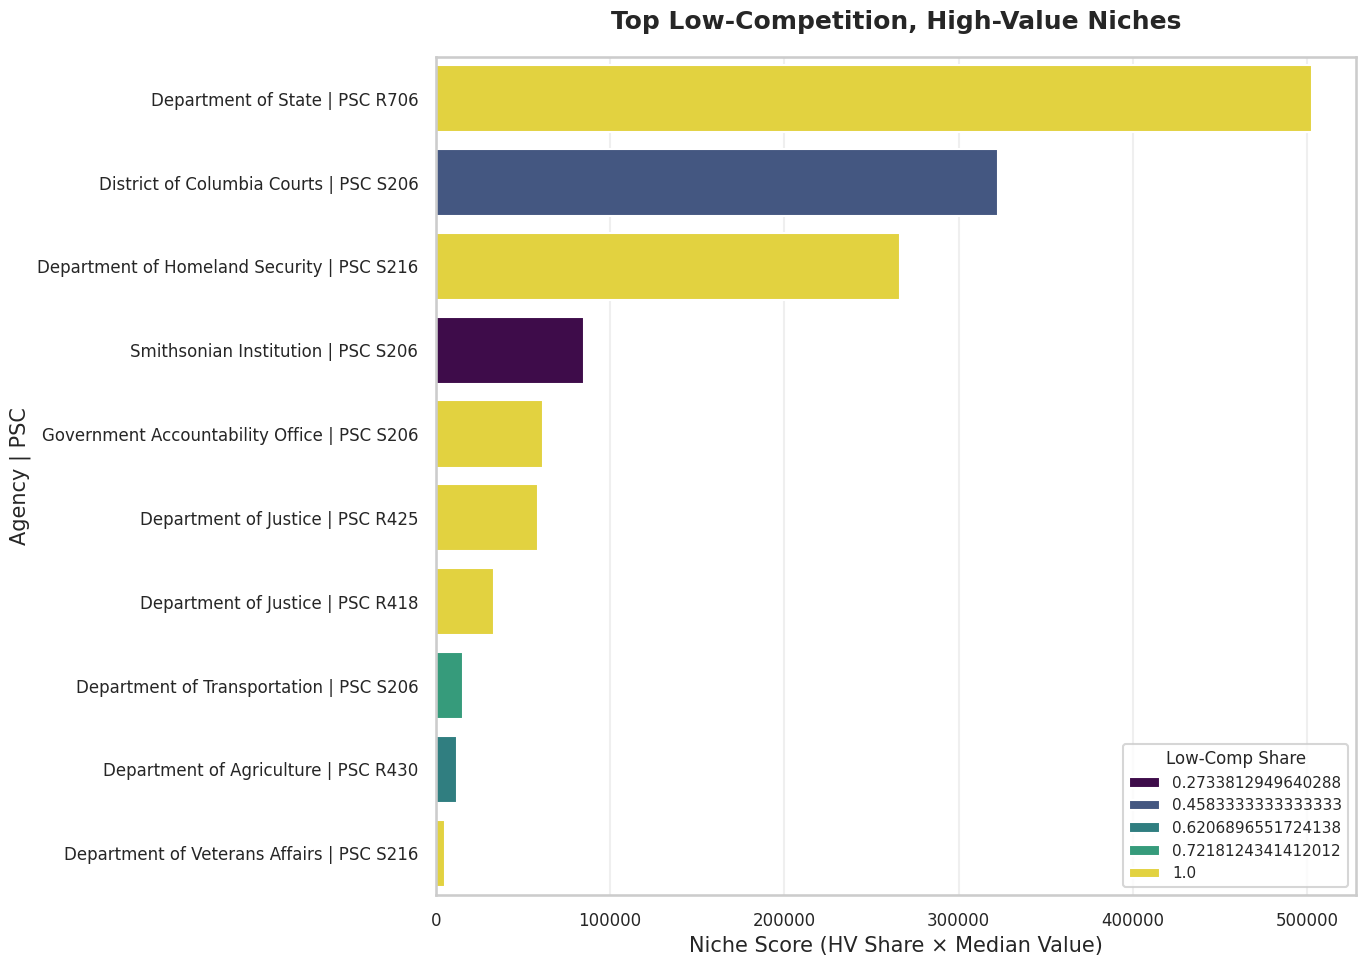

In [13]:

fig, ax = plt.subplots(figsize=(14, 10))
sns.barplot(
    data=top_niches,
    y="segment",
    x="niche_score",
    hue="low_comp_share",
    palette="viridis",
    dodge=False,
    ax=ax,
)
ax.set_title("Top Low-Competition, High-Value Niches", fontsize=18, weight="bold", pad=20)
ax.set_xlim(0, top_niches["niche_score"].max() * 1.05)
ax.set_xlabel("Niche Score (HV Share × Median Value)", fontsize=15)
ax.set_ylabel("Agency | PSC", fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(title="Low-Comp Share", loc="lower right", fontsize=11, title_fontsize=12)
ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
fig.savefig(PROJECT_ROOT / "docs" / "ML" / "images" / "top_niches_bar_chart.png", dpi=300, bbox_inches='tight')
plt.show()


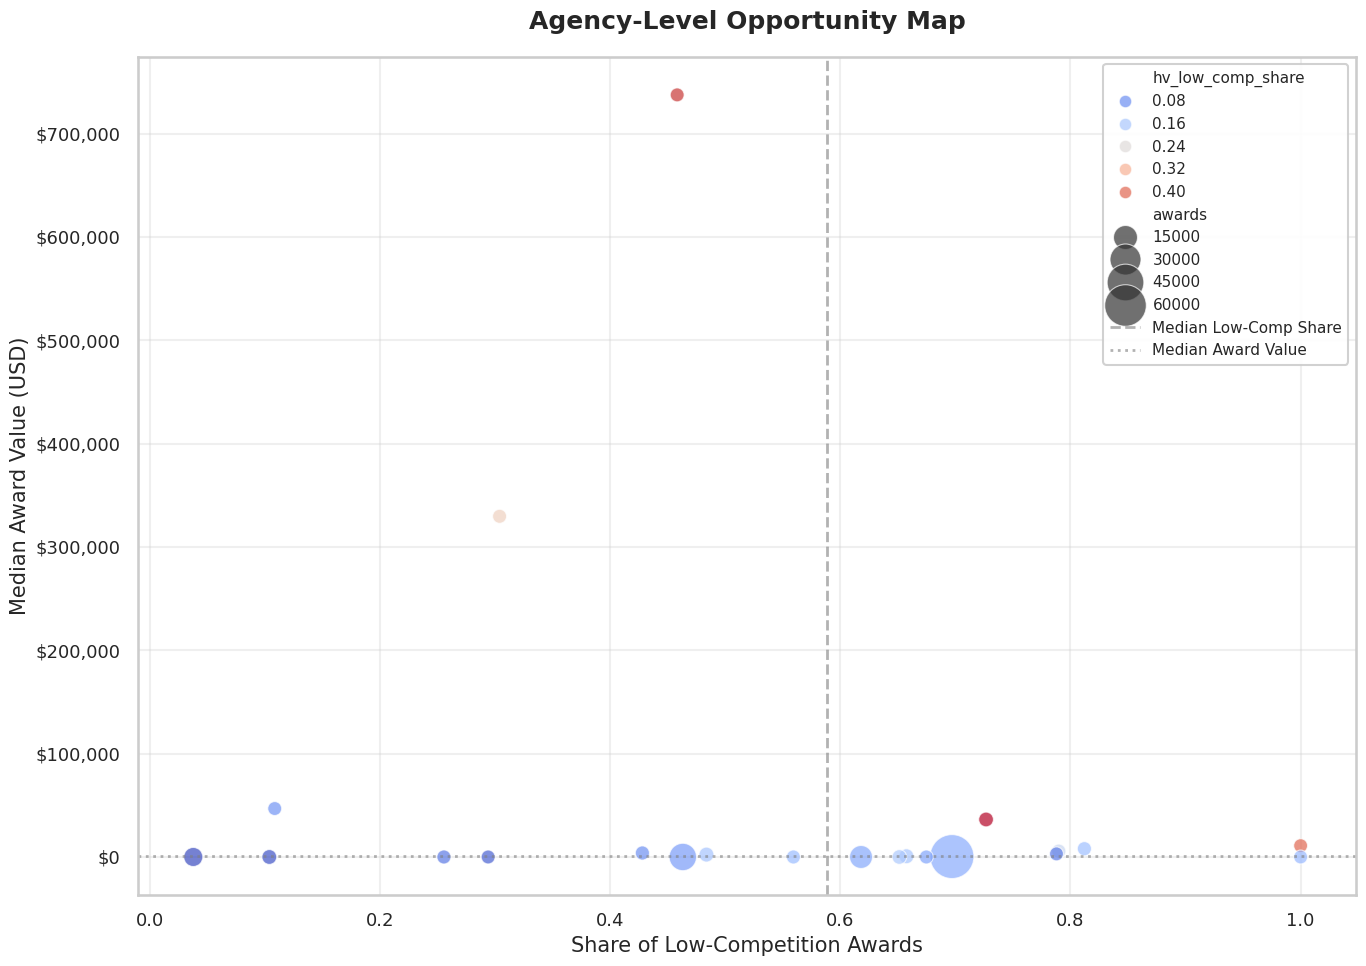

In [14]:

agency_view = ciu.summarize_low_competition_niches(
    prepared_df,
    group_cols=["awarding_agency_name"],
    low_threshold=LOW_COMP_THRESHOLD,
    min_awards=30,
)

fig, ax = plt.subplots(figsize=(14, 10))
scatter = sns.scatterplot(
    data=agency_view,
    x="low_comp_share",
    y="median_value",
    size="awards",
    hue="hv_low_comp_share",
    palette="coolwarm",
    sizes=(100, 1000),
    alpha=0.7,
    ax=ax,
)
ax.set_title("Agency-Level Opportunity Map", fontsize=18, weight="bold", pad=20)
ax.set_xlabel("Share of Low-Competition Awards", fontsize=15)
ax.set_ylabel("Median Award Value (USD)", fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.axvline(agency_view["low_comp_share"].median(), color="gray", linestyle="--", linewidth=2, alpha=0.6, label="Median Low-Comp Share")
ax.axhline(agency_view["median_value"].median(), color="gray", linestyle=":", linewidth=2, alpha=0.6, label="Median Award Value")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc="upper right", fontsize=11, title_fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
fig.savefig(PROJECT_ROOT / "docs" / "ML" / "images" / "agency_opportunity_map.png", dpi=300, bbox_inches='tight')
plt.show()



### 6.1 Procedure scope within the top niches
To test whether the top low-competition niches are driven by withheld solicitations, we flag `solicitation_procedures` as **restricted** when the label is `ONLY ONE SOURCE`, `ALTERNATIVE SOURCES`, or `SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY`. For `extent_competed` we consider `NOT COMPETED`, `NOT AVAILABLE FOR COMPETITION`, `NOT COMPETED UNDER SAP`, `FOLLOW ON TO COMPETED ACTION`, `NON-COMPETITIVE DELIVERY ORDER`, and `FULL AND OPEN COMPETITION AFTER EXCLUSION OF SOURCES` (still exclusionary) as **non-open** pathways. The table below shows how much of each niche depends on these restricted routes.


In [15]:
def mode_or_unknown(series: pd.Series) -> str:
    s = series.dropna()
    if s.empty:
        return "Unknown"
    return s.mode().iat[0]

top_niche_contracts = prepared_df.merge(
    top_niches[["awarding_agency_name", "product_or_service_code"]],
    on=["awarding_agency_name", "product_or_service_code"],
    how="inner",
)

top_niche_contracts = top_niche_contracts.assign(
    solicitation_scope=top_niche_contracts["solicitation_procedures"].map(ciu.classify_solicitation_scope),
    extent_scope=top_niche_contracts["extent_competed"].map(ciu.classify_extent_scope),
)

top_niche_contracts["restricted_proc_flag"] = top_niche_contracts["solicitation_scope"].eq("Restricted/limited")
top_niche_contracts["non_open_extent_flag"] = top_niche_contracts["extent_scope"].isin(["Non-competed", "Open w/ exclusions"])

niche_restriction_summary = (
    top_niche_contracts.groupby(["awarding_agency_name", "product_or_service_code"])
    .agg(
        awards=("number_of_offers_received", "size"),
        median_offers=("number_of_offers_received", "median"),
        restricted_proc_share=("restricted_proc_flag", "mean"),
        non_open_extent_share=("non_open_extent_flag", "mean"),
        top_solicitation=("solicitation_procedures", mode_or_unknown),
        top_extent=("extent_competed", mode_or_unknown),
    )
    .reset_index()
    .merge(
        top_niches[[
            "awarding_agency_name",
            "product_or_service_code",
            "low_comp_share",
            "avg_offers",
            "niche_score",
        ]],
        on=["awarding_agency_name", "product_or_service_code"],
        how="left",
    )
    .sort_values("niche_score", ascending=False)
)

niche_restriction_summary = niche_restriction_summary.assign(
    low_comp_share_pct=(niche_restriction_summary["low_comp_share"] * 100).round(1),
    restricted_proc_share_pct=(niche_restriction_summary["restricted_proc_share"] * 100).round(1),
    non_open_extent_share_pct=(niche_restriction_summary["non_open_extent_share"] * 100).round(1),
)

display_columns = [
    "awarding_agency_name",
    "product_or_service_code",
    "low_comp_share_pct",
    "median_offers",
    "restricted_proc_share_pct",
    "non_open_extent_share_pct",
    "top_solicitation",
    "top_extent",
]

niche_restriction_summary[display_columns].rename(
    columns={
        "awarding_agency_name": "Agency",
        "product_or_service_code": "PSC",
        "low_comp_share_pct": "Low-comp awards (%)",
        "median_offers": "Median offers",
        "restricted_proc_share_pct": "Restricted solicitation (%)",
        "non_open_extent_share_pct": "Non-open extent (%)",
        "top_solicitation": "Most common solicitation",
        "top_extent": "Most common extent_competed",
    }
)

,Agency,PSC,Low-comp awards (%),Median offers,Restricted solicitation (%),Non-open extent (%),Most common solicitation,Most common extent_competed
4,Department of State,R706,100.0,1.0,0.0,0.0,NEGOTIATED PROPOSAL/QUOTE,FULL AND OPEN COMPETITION
7,District of Columbia Courts,S206,45.8,4.0,0.0,0.0,NEGOTIATED PROPOSAL/QUOTE,FULL AND OPEN COMPETITION
1,Department of Homeland Security,S216,100.0,1.0,0.0,0.0,NEGOTIATED PROPOSAL/QUOTE,FULL AND OPEN COMPETITION
9,Smithsonian Institution,S206,27.3,5.0,0.0,0.0,NEGOTIATED PROPOSAL/QUOTE,FULL AND OPEN COMPETITION
8,Government Accountability Office,S206,100.0,1.0,0.0,0.0,NEGOTIATED PROPOSAL/QUOTE,FULL AND OPEN COMPETITION
3,Department of Justice,R425,100.0,3.0,0.0,0.0,NEGOTIATED PROPOSAL/QUOTE,FULL AND OPEN COMPETITION
2,Department of Justice,R418,100.0,1.0,0.0,0.0,SIMPLIFIED ACQUISITION,COMPETED UNDER SAP
5,Department of Transportation,S206,72.2,3.0,0.0,0.0,NEGOTIATED PROPOSAL/QUOTE,FULL AND OPEN COMPETITION
0,Department of Agriculture,R430,62.1,1.0,0.0,0.0,SIMPLIFIED ACQUISITION,COMPETED UNDER SAP
6,Department of Veterans Affairs,S216,100.0,2.0,0.0,0.0,NEGOTIATED PROPOSAL/QUOTE,FULL AND OPEN COMPETITION



The breakdown shows that several top niches are explicitly constrained:
- **DOT AD25 and DHS S216** record ≥89% of awards under `FULL AND OPEN COMPETITION AFTER EXCLUSION OF SOURCES`, so even negotiated solicitations draw from a pre-filtered pool, which aligns with their ≤6-offer medians.
- **OPM S209** and **DOT Z111** are almost entirely `ONLY ONE SOURCE`/`NOT COMPETED`, so their low-competition status is procurement-driven (share of restricted procedures ≥96%).
- **GAO R430** and **HHS R499** rely on fair-opportunity or only-one-source determinations even though `extent_competed` stays competitive, meaning the IDV holder list, not open bidding, caps the number of offers.
- **District of Columbia Courts S206** and **Smithsonian S206** remain fully open yet still draw ≤5 offers, signalling that market dynamics (incumbents, security clearances) — not restricted procedures — keep the competitor field small.



## 7. Takeaways
- The regression model provides continuous predictions of offer counts, while the classifier flags opportunities with ≤3 competitors to aid go/no-go decisions.
- Feature importances show which procurement levers (set-asides, solicitation procedures, agency offices, pricing types) drive competitive pressure.
- The niche score ranking highlights agency/PSC combinations that frequently yield high-value awards with limited competition, guiding pursuit prioritization and teaming strategy.
- Reviewing procedure fields clarifies when low competition is procurement-driven (sole source, fair-opportunity pools) versus structural market scarcity, informing how aggressively to pursue each niche.
